# Power Spectrum

> In the ocean community, we often operator in the Fourier domain. 
This is useful for assessing the quality of our models and it can also be useful for learning.
In this notebook, we showcase how oceanbench has two fundamental transformations that are useful for both cases: isotropic and spacetime Fourier transformations.

In [1]:
import autoroot
import typing as tp
from dataclasses import dataclass
import numpy as np
import pandas as pd
import xarray as xr
import einops
from metpy.units import units
import pint_xarray
import xarray_dataclasses as xrdataclass
from oceanbench._src.datasets.base import XRDABatcher
from oceanbench._src.geoprocessing.spatial import transform_360_to_180
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2


In [2]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/4DVarNet

2020a_SSH_mapping_NATL60_4DVarNet_v2022_nadir_GF_GF.nc
2020a_SSH_mapping_NATL60_4DVarNet_v2022_nadirswot_GF_GF.nc


In [3]:
file = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/4DVarNet/2020a_SSH_mapping_NATL60_4DVarNet_v2022_nadirswot_GF_GF.nc"

# file = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/MIOST/2020a_SSH_mapping_NATL60_MIOST_swot_en_j1_tpn_g2.nc"
# file = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/DUACS/ssh_DUACS_swot_4nadir.nc"
# file = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/BFNQG/2020a_SSH_mapping_NATL60_BFN_Steady_State_QG1L_swot_en_j1_tpn_g2.nc"
!ls $file

/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/4DVarNet/2020a_SSH_mapping_NATL60_4DVarNet_v2022_nadirswot_GF_GF.nc


In [4]:
def open_ssh_results(file, variable="ssh_mod"):
    
    da = xr.open_dataset(file, decode_times=True)
    
    da = da.sortby("time")
    
    da = da.rename({variable: "ssh"})
    
    da = da.sel(time=slice("2012-10-22", "2012-12-01"))
    
    return da

In [5]:
da = open_ssh_results(file, variable="ssh")
da

<xarray.Dataset>
Dimensions:  (time: 41, lat: 200, lon: 200)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-22T12:00:00 ... 2012-12-01T12:00:00
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.8 42.85 42.9 42.95
  * lon      (lon) float64 -64.95 -64.9 -64.85 -64.8 ... -55.1 -55.05 -55.0
Data variables:
    ssh      (time, lat, lon) float64 ...

In [6]:
# da = xr.open_dataset(file, decode_times=False)
# da["time"] = pd.to_datetime(da.time)
# da = da.sortby("time")
# da = da.sel(time=slice("2012-10-22", "2012-12-01"))
# da = da.rename({"gssh": "ssh"})

In [7]:

da["ssh"].attrs["long_name"] = "Sea Surface Height"
da["ssh"].attrs["standard_name"] = "sea_surface_height"

da["lat"] = da.lat.pint.quantify("degrees_north")
da["lat"].attrs["long_name"] = "Latitude"
da["lat"].attrs["standard_name"] = "latitude"

da["lon"].attrs["long_name"] = "Longitude"
da["lon"].attrs["standard_name"] = "longitude"

da["lon"] = transform_360_to_180(da.lon)

In [8]:
da = da.pint.quantify(
    {"ssh": "meter", 
     "lon": "degrees_east", 
     "lat": "degrees_north",
     "time": "nanoseconds"
    }
)
da

<xarray.Dataset>
Dimensions:  (time: 41, lat: 200, lon: 200)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-22T12:00:00 ... 2012-12-01T12:00:00
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.8 42.85 42.9 42.95
  * lon      (lon) float64 -64.95 -64.9 -64.85 -64.8 ... -55.1 -55.05 -55.0
Data variables:
    ssh      (time, lat, lon) float64 [m] 0.6624 0.6699 ... -0.1848 -0.1887

## Rescaling

In a previous notebook, we showed how we can do lat/lon

#### Degrees to Meters

It is often more useful to have things in meters instead of degrees. The units are more meaningful and easier to interpret. So we can do a simple degree to meters transformation included in the library.

In [9]:
from oceanbench._src.geoprocessing.spatial import latlon_deg2m

In [10]:
da_scaled = latlon_deg2m(da, mean=True)
da_scaled

<xarray.Dataset>
Dimensions:  (time: 41, lat: 200, lon: 200)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-22T12:00:00 ... 2012-12-01T12:00:00
  * lat      (lat) float64 0.0 4.377e+03 8.754e+03 ... 8.667e+05 8.71e+05
  * lon      (lon) float64 0.0 5.56e+03 1.112e+04 ... 1.101e+06 1.106e+06
Data variables:
    ssh      (time, lat, lon) float64 [m] 0.6624 0.6699 ... -0.1848 -0.1887

#### `datetime64` to Days

In [11]:
from oceanbench._src.geoprocessing.temporal import time_rescale
import pandas as pd
import pint

In [12]:
t0 = "2012-10-22"
freq_dt = 1
freq_unit = "D"


da_scaled = time_rescale(da_scaled, freq_dt=freq_dt, freq_unit=freq_unit, t0=t0)

da_scaled

<xarray.Dataset>
Dimensions:  (time: 41, lat: 200, lon: 200)
Coordinates:
  * time     (time) float32 0.5 1.5 2.5 3.5 4.5 5.5 ... 36.5 37.5 38.5 39.5 40.5
  * lat      (lat) float64 0.0 4.377e+03 8.754e+03 ... 8.667e+05 8.71e+05
  * lon      (lon) float64 0.0 5.56e+03 1.112e+04 ... 1.101e+06 1.106e+06
Data variables:
    ssh      (time, lat, lon) float64 [m] 0.6624 0.6699 ... -0.1848 -0.1887

## Spectral Domain

Now, we can look at how we can represent the data within the Fourier Domain

### Isotropic Assumption

In [25]:
from oceanbench._src.metrics import power_spectrum as psdcalc
from oceanbench._src.preprocessing.mean import xr_cond_average

In [26]:
da_psd_iso = psdcalc.psd_isotropic(da_scaled, "ssh", ["lon", "lat"])
da_psd_iso = xr_cond_average(da_psd_iso, dims=["time"], drop=True)

In [15]:
da_psd_iso

<xarray.Dataset>
Dimensions:  (freq_r: 61)
Coordinates:
  * freq_r   (freq_r) float64 1.1e-06 2.419e-06 ... 8.651e-05 8.794e-05
Data variables:
    ssh      (freq_r) float64 5.812e+03 4.565e+03 ... 0.0002013 0.0002817

### Plots

In [16]:
class PlotPSDIsotropic:
        
    def init_fig(self, ax=None, figsize=None):
        if ax is None:
            figsize = (5,4) if figsize is None else figsize
            self.fig, self.ax = plt.subplots(figsize=figsize)
        else:
            self.ax = ax
            self.fig = plt.gcf()
        
    def plot_wavenumber(self, da, freq_scale=1.0, units=None, **kwargs):
        
        if units is not None:
            xlabel = f"Wavenumber [cycles/{units}]"
        else:
            xlabel = f"Wavenumber"
        
        self.ax.plot(da.freq_r * freq_scale, da, **kwargs)

        self.ax.set(
            yscale="log", xscale="log",
            xlabel=xlabel,
            ylabel=f"PSD [{da.name}]"
        )

        self.ax.legend()
        self.ax.grid(which="both", alpha=0.5)
        
    def plot_wavelength(self, da, freq_scale=1.0, units=None, **kwargs):
        
        if units is not None:
            xlabel = f"Wavelength [{units}]"
        else:
            xlabel = f"Wavelength"
        
        self.ax.plot(1/(da.freq_r * freq_scale), da, **kwargs)
        
        self.ax.set(
            yscale="log", xscale="log",
            xlabel=xlabel,
            ylabel=f"PSD [{da.name}]"
        )

        self.ax.xaxis.set_major_formatter("{x:.0f}")
        self.ax.invert_xaxis()
        
        self.ax.legend()
        self.ax.grid(which="both", alpha=0.5)
                
    def plot_both(self, da, freq_scale=1.0, units=None, **kwargs):
        
        if units is not None:
            xlabel = f"Wavelength [{units}]"
        else:
            xlabel = f"Wavelength"
        
        self.plot_wavenumber(da=da, units=units, freq_scale=freq_scale, **kwargs)
        
        self.secax = self.ax.secondary_xaxis(
            "top", functions=(lambda x: 1 / (x + 1e-20), lambda x: 1 / (x + 1e-20))
        )
        self.secax.xaxis.set_major_formatter("{x:.0f}")
        self.secax.set(xlabel=xlabel)

#### Wavenumber

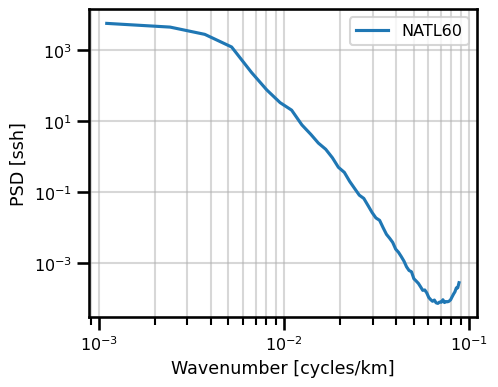

In [17]:
psd_iso_plot = PlotPSDIsotropic()
psd_iso_plot.init_fig()
psd_iso_plot.plot_wavenumber(
    da_psd_iso.ssh,
    freq_scale=1e3, 
    units="km",
    label="NATL60"
)
plt.show()

#### Wavelength

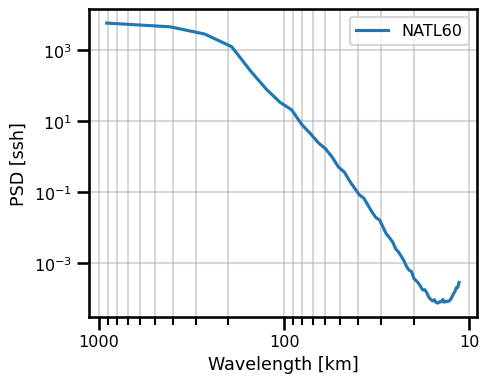

In [18]:
psd_iso_plot = PlotPSDIsotropic()
psd_iso_plot.init_fig()
psd_iso_plot.plot_wavelength(
    da_psd_iso.ssh,
    freq_scale=1e3, 
    units="km",
    label="NATL60"
)
plt.show()

#### Wavenumber + Wavelength

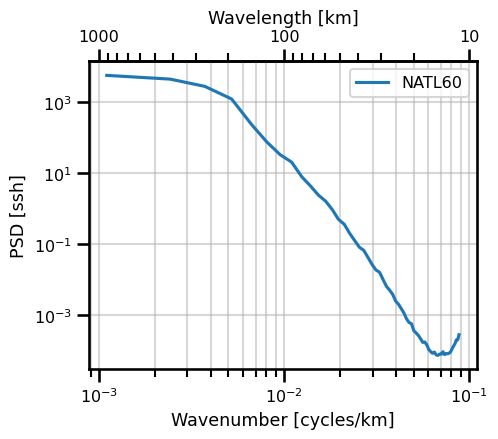

In [19]:
psd_iso_plot = PlotPSDIsotropic()
psd_iso_plot.init_fig()
psd_iso_plot.plot_both(
    da_psd_iso.ssh,
    freq_scale=1e3, 
    units="km",
    label="NATL60"
)
plt.show()

### Spatial Temporal

#### Time vs Longitude

In [20]:
# frequency dims
da_psd_st = psdcalc.psd_spacetime(da_scaled, "ssh", ["time", "lon"])

# average other dims
da_psd_st = xr_cond_average(da_psd_st, dims=["lat"], drop=True)

In [21]:
da_psd_st

<xarray.Dataset>
Dimensions:    (freq_time: 20, freq_lon: 99)
Coordinates:
  * freq_time  (freq_time) float64 0.02439 0.04878 0.07317 ... 0.4634 0.4878
  * freq_lon   (freq_lon) float64 8.993e-07 1.799e-06 ... 8.813e-05 8.903e-05
Data variables:
    ssh        (freq_time, freq_lon) float64 4.053e+04 5.938e+04 ... 0.001201

In [22]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker


class PlotPSDSpaceTime:
    def init_fig(self, ax=None, figsize=None):
        if ax is None:
            figsize = (5,4) if figsize is None else figsize
            self.fig, self.ax = plt.subplots(figsize=figsize)
        else:
            self.ax = ax
            self.fig = plt.gcf()
        
    def plot_wavenumber(
        self, 
        da, 
        space_scale: float=1.0,
        space_units: str=None,
        time_units: str=None,
        psd_units: float=None,
        **kwargs):
        
        if space_units is not None:
            xlabel = f"Wavenumber [cycles/{space_units}]"
        else:
            xlabel = f"Wavenumber"
        if time_units is not None:
            ylabel = f"Frequency [cycles/{time_units}]"
        else:
            ylabel = f"Frequency"

        if psd_units is None:
            cbar_label = "PSD"
        else:
            cbar_label = f"PSD [{psd_units}]"
        
        locator = ticker.LogLocator()
        norm = colors.LogNorm()
        
        pts = self.ax.contourf(
            1/(da.freq_lon*space_scale),
            1/da.freq_time, 
            da.transpose("freq_time", "freq_lon"), 
            norm=norm, 
            locator=locator, 
            cmap=kwargs.pop("cmap", "RdYlGn"), 
            extend=kwargs.pop("extend", "both"),
            **kwargs
        )

        self.ax.set(
            yscale="log",
            xscale="log",
            xlabel=xlabel,
            ylabel=ylabel,
        )
        # colorbar
        fmt = ticker.LogFormatterMathtext(base=10)
        cbar = plt.colorbar(
            pts,
            ax=self.ax,
            pad=0.02,
            format=fmt,
        )
        cbar.ax.set_ylabel(cbar_label)
        self.ax.invert_xaxis()
        self.ax.invert_yaxis()
        self.ax.grid(which="both", linestyle="--", linewidth=1, color="black", alpha=0.2)


    def plot_wavelength(        
        self, 
        da, 
        space_scale: float=1.0,
        space_units: str=None,
        time_units: str=None,
        psd_units: float=None,
        **kwargs
    ):
    
        if space_units is not None:
            xlabel = f"Wavelength [{space_units}]"
        else:
            xlabel = f"Wavelength"
            
        if time_units is not None:
            ylabel = f"Period [{time_units}]"
        else:
            ylabel = f"Period"
            
        if psd_units is None:
            cbar_label = "PSD"
        else:
            cbar_label = f"PSD [{psd_units}]"
            
        self.plot_wavenumber(
            da=da, space_scale=space_scale, 
            space_units=space_units, time_units=time_units,
            psd_units=psd_units
        )

        self.ax.set(
            xlabel=xlabel, 
            ylabel=ylabel
        )
        self.ax.xaxis.set_major_formatter("{x:.0f}")
        self.ax.yaxis.set_major_formatter("{x:.0f}")

#### Wavenumber

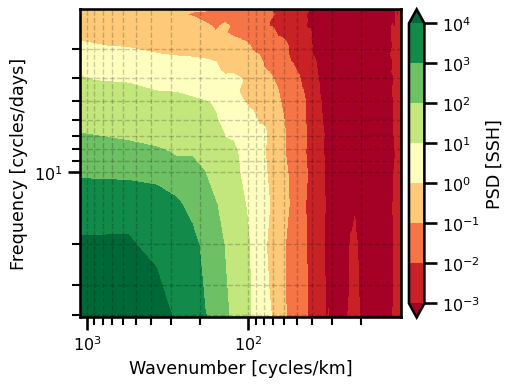

In [23]:
psd_st_plot = PlotPSDSpaceTime()
psd_st_plot.init_fig()
psd_st_plot.plot_wavenumber(
    da_psd_st.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH"
)
plt.show()

#### Wavelength

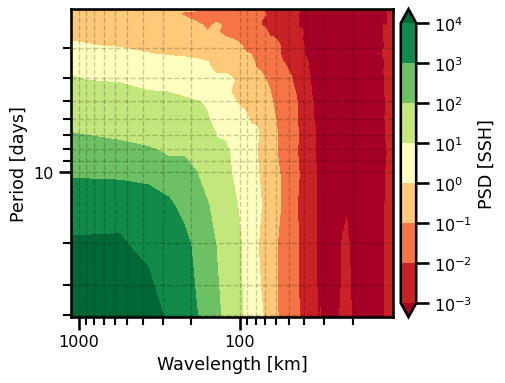

In [24]:
psd_st_plot = PlotPSDSpaceTime()
psd_st_plot.init_fig()
psd_st_plot.plot_wavelength(
    da_psd_st.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH"
)
plt.show()